## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
#AP commenting out exporting code with two ## so export files aren't updated unneccessarily every time the cell is run
from sklearn.datasets import load_iris
##iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
##model = RandomForestClassifier(n_estimators=10)

# Train
##model.fit(iris.data, iris.target)
# Extract single tree
##estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
##export_graphviz(estimator, out_file='tree.dot', 
##                feature_names = iris.feature_names,
##                class_names = iris.target_names,
##                rounded = True, proportion = False, 
##                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
##call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
##Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


AP: Notes about the cols from the dataset source:

- infection_case
    - The value 'overseas inflow' means that the infection is from other country.
    - The value 'etc' includes individual cases, cases where relevance classification is ongoing after investigation, and cases under investigation.
- city: City(-si) / Country (-gun) / District (-gu)
    - The value 'from other city' means that where the group infection started is other city.
- age: the age of the patient
    - 0s: 0 ~ 9
    - 10s: 10 ~ 19
    - 90s: 90 ~ 99
    - 100s: 100 ~ 109
- patient_id: the ID of the patient
    - patient_id(10) = region_code(5) + patient_number(5)
    - You can check the region_code in 'Region.csv' #AP: Don't have this datafile
    - There are two types of the patient_number
        - 1) local_num: The number given by the local government.
        - 2) global_num: The number given by the KCDC
- sex: the sex of the patient
- age: the age of the patient
    - 0s: 0 ~ 9
    - 10s: 10 ~ 19
    - 90s: 90 ~ 99
    - 100s: 100 ~ 109
- country: the country of the patient
- province: the province of the patient
- city: the city of the patient
- infection_case: the case of infection
- infected_by: the ID of who infected the patient
    - This column refers to the 'patient_id' column.
- contact_number: the number of contacts with people
- symptom_onset_date: the date of symptom onset
- confirmed_date: the date of being confirmed
- released_date: the date of being released
- deceased_date: the date of being deceased
- state: isolated / released / deceased
    - isolated: being isolated in the hospital
    - released: being released from the hospital
    - deceased: being deceased

In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
df['birth_year'].dtypes

dtype('float64')

In [8]:
df['n_age'] = datetime.now().year - df['birth_year']
df['n_age'].head()

0    60.0
1    37.0
2    60.0
3    33.0
4    32.0
Name: n_age, dtype: float64

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
print(df.isnull().sum().sort_values(ascending=False))

disease               2199
deceased_date         2186
infection_order       2176
symptom_onset_date    2025
released_date         1995
contact_number        1807
infected_by           1749
infection_case        1055
global_num             904
n_age                  454
birth_year             454
age                    261
sex                    145
confirmed_date         141
state                   88
city                    65
province                 0
country                  0
patient_id               0
dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
df['disease'].unique()

array([nan, True], dtype=object)

In [12]:
df["disease"] = df["disease"].fillna(0)
df["disease"] = df["disease"].replace('True', 1)
df['disease'].unique()

array([0, True], dtype=object)

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [13]:
df["global_num"] = df["global_num"].fillna(df['global_num'].mean())
#AP I think either a ffill or bfill method would be more appropriate since this seems to be a running total of COVID cases
df["birth_year"] = df["birth_year"].fillna(df['birth_year'].mean())
df["infection_order"] = df["infection_order"].fillna(df['infection_order'].mean())
#AP: note: I don't agree with using mean since this seems to denote order of infection from one person to another, it's categorical in nature. Using so I can continue with case study and maybe figure out why this choice was made
df["infected_by"] = df["infected_by"].fillna(df['infected_by'].mean())
#AP: note: I don't agree with using mean since this notes the paitent ID that infected the person. Using so I can continue with case study and maybe figure out why this choice was made
df["contact_number"] = df["contact_number"].fillna(df['contact_number'].mean())

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [14]:
df.isnull().sum().sort_values(ascending=False)

deceased_date         2186
symptom_onset_date    2025
released_date         1995
infection_case        1055
n_age                  454
age                    261
sex                    145
confirmed_date         141
state                   88
city                    65
country                  0
province                 0
disease                  0
global_num               0
infection_order          0
infected_by              0
contact_number           0
birth_year               0
patient_id               0
dtype: int64

In [15]:
#AP: To get an idea of the data in each col
null_remaining_cols = ['deceased_date', 'symptom_onset_date', 'released_date', 'infection_case', 'n_age', 'age', 'sex', 'confirmed_date', 'state', 'city']
df[null_remaining_cols].head()

,deceased_date,symptom_onset_date,released_date,infection_case,n_age,age,sex,confirmed_date,state,city
0,NaN,2020-01-22,2020-02-05,overseas inflow,60.0,50s,male,2020-01-23,released,Gangseo-gu
1,NaN,NaN,2020-03-02,overseas inflow,37.0,30s,male,2020-01-30,released,Jungnang-gu
2,NaN,NaN,2020-02-19,contact with patient,60.0,50s,male,2020-01-30,released,Jongno-gu
3,NaN,2020-01-26,2020-02-15,overseas inflow,33.0,20s,male,2020-01-30,released,Mapo-gu
4,NaN,NaN,2020-02-24,contact with patient,32.0,20s,female,2020-01-31,released,Seongbuk-gu


In [16]:
df[null_remaining_cols].dtypes

deceased_date          object
symptom_onset_date     object
released_date          object
infection_case         object
n_age                 float64
age                    object
sex                    object
confirmed_date         object
state                  object
city                   object
dtype: object

AP: Plan for dealing with each col's missing values:

- deceased_date: -DROPPING ANYWAY- Figure out what to impute to denote patient not deceased, zero (0)(?)
- symptom_onset_date: -DROPPING ANYWAY- Figure out what to impute if no symptoms, zero (0) to possibly allow calc's with date style col(?)
- released_date: -DONE- -DROPPING ANYWAY- 'unknown' since nulls vastly outnumber actual values
- infection_case: -DONE- impute and replace 'etc' with 'unknown' ~fill with "contact with patient" (would this make the data too skewed towards that infection vector?)~
- n_age: -DONE- mean
- age: -DONE- mean (rounded to nearest tens place)
- sex: -DONE- fill half with male & half with female
    - could do df['sex'].ffill() but that seems to make it too lopsided toward female
    - combine df['sex'].sample(frac=1, random_state=1234) with .ffill()
- confirmed_date: -DONE- -DROPPING ANYWAY- mean
- state: -DONE- mode
- city: -DONE- mode

In [17]:
# confirmed_date col, impute with mean
# this col getting dropped later but keeping this code as good example
df['confirmed_date'] = pd.to_datetime(df['confirmed_date'].str.strip(), format='%Y-%m-%d')

In [18]:
df['confirmed_date'].value_counts(dropna=False)

confirmed_date
NaT           141
2020-03-01    133
2020-02-28    125
2020-02-26    123
2020-03-03    113
2020-03-04    106
2020-02-27    106
2020-03-05    102
2020-02-29     99
2020-03-06     97
2020-03-10     94
2020-02-25     93
2020-02-23     71
2020-02-22     70
2020-03-09     69
2020-03-02     66
2020-02-24     56
2020-03-07     54
2020-03-16     53
2020-03-08     53
2020-03-11     49
2020-02-20     41
2020-03-12     37
2020-03-15     36
2020-03-13     35
2020-03-17     33
2020-02-21     33
2020-03-18     32
2020-03-14     31
2020-02-19     28
2020-02-18      9
2020-02-05      5
2020-01-31      4
2020-02-09      3
2020-02-02      3
2020-01-30      3
2020-02-16      2
2020-02-06      2
2020-02-07      1
2020-02-04      1
2020-01-20      1
2020-01-26      1
2020-01-27      1
2020-02-01      1
2020-02-10      1
2020-01-23      1
Name: count, dtype: int64

In [19]:
datetime.date(df['confirmed_date'].mean())

datetime.date(2020, 3, 2)

In [20]:
# this col getting dropped later but keeping this code as good example
df['confirmed_date'] = df['confirmed_date'].fillna(datetime.date(df['confirmed_date'].mean()))
df['confirmed_date'].value_counts(dropna=False)

confirmed_date
2020-03-02             141
2020-03-01 00:00:00    133
2020-02-28 00:00:00    125
2020-02-26 00:00:00    123
2020-03-03 00:00:00    113
2020-03-04 00:00:00    106
2020-02-27 00:00:00    106
2020-03-05 00:00:00    102
2020-02-29 00:00:00     99
2020-03-06 00:00:00     97
2020-03-10 00:00:00     94
2020-02-25 00:00:00     93
2020-02-23 00:00:00     71
2020-02-22 00:00:00     70
2020-03-09 00:00:00     69
2020-03-02 00:00:00     66
2020-02-24 00:00:00     56
2020-03-07 00:00:00     54
2020-03-16 00:00:00     53
2020-03-08 00:00:00     53
2020-03-11 00:00:00     49
2020-02-20 00:00:00     41
2020-03-12 00:00:00     37
2020-03-15 00:00:00     36
2020-03-13 00:00:00     35
2020-03-17 00:00:00     33
2020-02-21 00:00:00     33
2020-03-18 00:00:00     32
2020-03-14 00:00:00     31
2020-02-19 00:00:00     28
2020-02-18 00:00:00      9
2020-02-05 00:00:00      5
2020-01-31 00:00:00      4
2020-02-09 00:00:00      3
2020-02-02 00:00:00      3
2020-01-30 00:00:00      3
2020-02-16 00

In [21]:
# n_age col, impute with mean (rounded to nearest year)
df['n_age'] = df['n_age'].fillna(round(df['n_age'].mean(),0))
df['n_age'].value_counts(dropna=False)

n_age
49.0     482
55.0      54
29.0      51
26.0      47
28.0      45
        ... 
14.0       2
13.0       2
99.0       1
108.0      1
93.0       1
Name: count, Length: 96, dtype: int64

In [22]:
# age col, impute with mean rounded to tens place

# first need to drop the 's'
df['age'] = df['age'].str.replace('s', '')
df['age'] = df['age'].astype('float64')
df['age'].value_counts(dropna=False)

age
20.0     467
50.0     385
40.0     303
NaN      261
30.0     251
60.0     229
70.0     117
80.0      84
10.0      74
0.0       29
90.0      17
100.0      1
Name: count, dtype: int64

In [23]:
df['age'] = df['age'].fillna(round(df['age'].mean(), -1))
#rename 'age' col to more appropriate 'age_group'
df = df.rename(columns={'age': 'age_group'})
df['age_group'].value_counts(dropna=False)

age_group
40.0     564
20.0     467
50.0     385
30.0     251
60.0     229
70.0     117
80.0      84
10.0      74
0.0       29
90.0      17
100.0      1
Name: count, dtype: int64

In [24]:
# Infection Case col: impute with 'unknown'
df['infection_case'] = df['infection_case'].fillna('unknown')

# also change etc value to 'unknown' since functionally the same but 'unknown' is more readily understood
df['infection_case'] = df['infection_case'].replace('etc', 'unknown')

df['infection_case'].value_counts(dropna=False)

infection_case
unknown                             1275
contact with patient                 530
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: count, dtype: int64

In [25]:
# City & state cols: impute with mode for each
city_state_fill = {'city' : df['city'].mode()[0], 'state' : df['state'].mode()[0]}
df[['city', 'state']] = df[['city', 'state']].fillna(value=city_state_fill)
#AP df['city'].mode() outputs a dict-like object, need to specify the value for it to work
#df['city'] = df['city'].replace(to_replace = np.nan, value = df['city'].mode()[0])
    #potentially useful code to do same thing, didn't test since I figured out other code's problem
print(df[['city', 'state']].isnull().sum().sort_values(ascending=False))

city     0
state    0
dtype: int64


In [26]:
# released_date col: impute with 'unknown'
# this col getting dropped later but keeping this code as good example
df['released_date'].value_counts(dropna=False)
df['released_date'] = df['released_date'].fillna('unkown')
print(df[['released_date']].isnull().sum().sort_values(ascending=False))

released_date    0
dtype: int64


In [27]:
# sex col: fill half with 'male' & other half with 'female'. Attempting to do so randomly
sex_missing_cols, sex_missing_rows = (
    (df[['sex']].isnull().sum(x) | df[['sex']].eq('').sum(x))
    .loc[lambda x: x.gt(0)].index
    for x in (0, 1))
print(df['sex'].value_counts(dropna=False))
df[['sex']].loc[sex_missing_rows, sex_missing_cols]

sex
female    1171
male       902
NaN        145
Name: count, dtype: int64


,sex
895,NaN
1724,NaN
1726,NaN
1727,NaN
1728,NaN
...,...
1946,NaN
1947,NaN
2159,NaN
2160,NaN


In [28]:
#df[['sex']].loc[sex_missing_rows, sex_missing_cols] = df[['sex']].loc[sex_missing_rows, sex_missing_cols]
df['sex'] = df['sex'].sample(frac=1, random_state=1234).ffill()
#a = df.loc[df.sex == 'NaN', 'sex']
#df.loc[(a if len(a.index) < 72 else a.sample(72)).index, 'sex'] = 'male'
df['sex'].value_counts(dropna=False)

sex
female    1250
male       968
Name: count, dtype: int64

In [29]:
#AP: Handy piece of code I learned from: https://stackoverflow.com/questions/27159189/find-empty-or-nan-entry-in-pandas-dataframe
missing_cols, missing_rows = (
    (df[['city']].isnull().sum(x) | df[['city']].eq('').sum(x))
    .loc[lambda x: x.gt(0)].index
    for x in (0, 1))
df[['city']].loc[missing_rows, missing_cols]

""


 **<font color='teal'> Check for any remaining null values.</font>**

In [30]:
print(df.isnull().sum().sort_values(ascending=False))

deceased_date         2186
symptom_onset_date    2025
patient_id               0
infection_order          0
state                    0
released_date            0
confirmed_date           0
contact_number           0
infected_by              0
infection_case           0
global_num               0
disease                  0
city                     0
province                 0
country                  0
age_group                0
birth_year               0
sex                      0
n_age                    0
dtype: int64


Remove date columns from the data.


In [31]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [32]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           97
age_group            11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                96
dtype: int64


Review the percent of unique values by column.

In [33]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043733
age_group          0.004959
country            0.001803
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001353
n_age              0.043282
dtype: float64


Review the range of values per column.

In [34]:
#df.describe().T
# AP: I like the non-transposed better
df.describe()

,patient_id,global_num,birth_year,age_group,infection_order,infected_by,contact_number,n_age
count,2.218000e+03,2218.000000,2218.000000,2218.000000,2218.000000,2.218000e+03,2218.000000,2218.000000
mean,4.014678e+09,4664.816591,1974.988662,40.441839,2.285714,2.600789e+09,24.128954,49.009017
std,2.192419e+09,2211.785463,17.311232,18.274297,0.170662,7.216328e+08,39.171414,17.311232
min,1.000000e+09,1.000000,1916.000000,0.000000,1.000000,1.000000e+09,0.000000,4.000000
25%,1.700000e+09,4205.250000,1965.000000,20.000000,2.285714,2.600789e+09,24.128954,36.000000
50%,6.001000e+09,4664.816591,1974.988662,40.000000,2.285714,2.600789e+09,24.128954,49.000000
75%,6.004000e+09,5900.250000,1988.000000,50.000000,2.285714,2.600789e+09,24.128954,59.000000
max,7.000000e+09,8717.000000,2020.000000,100.000000,6.000000,6.113000e+09,1160.000000,108.000000


### Check for duplicated rows

In [35]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age_group,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [36]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,134
4,disease,2
5,infection_case,16
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [37]:
df.dtypes

patient_id           int64
global_num         float64
sex                 object
birth_year         float64
age_group          float64
country             object
province            object
city                object
disease             object
infection_case      object
infection_order    float64
infected_by        float64
contact_number     float64
state               object
n_age              float64
dtype: object

<Axes: >

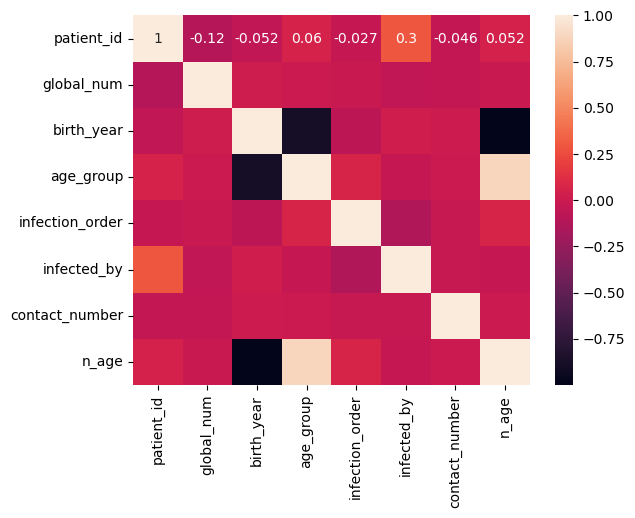

In [38]:
plt.figure()
sns.heatmap(df.corr(numeric_only=True), annot=True)
#AP: numeric_only since default is false

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

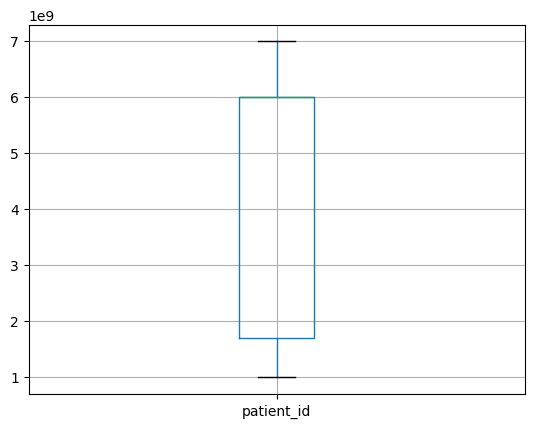

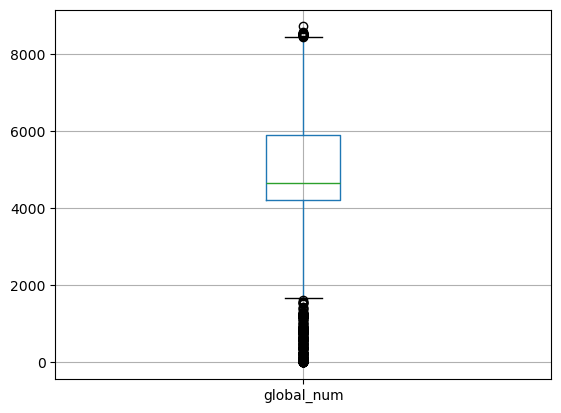

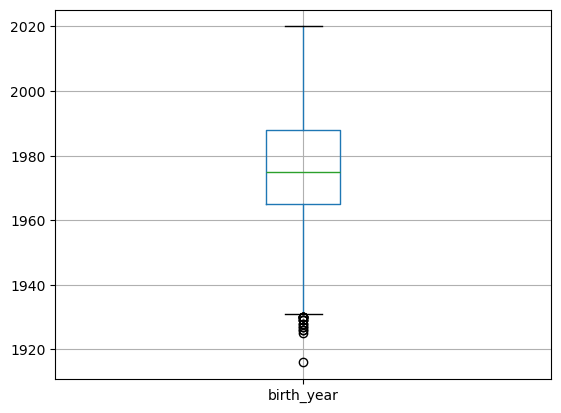

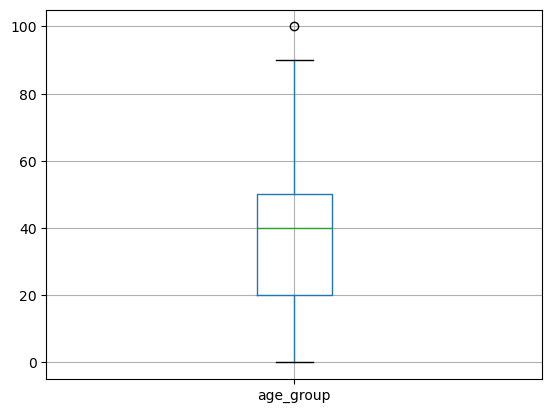

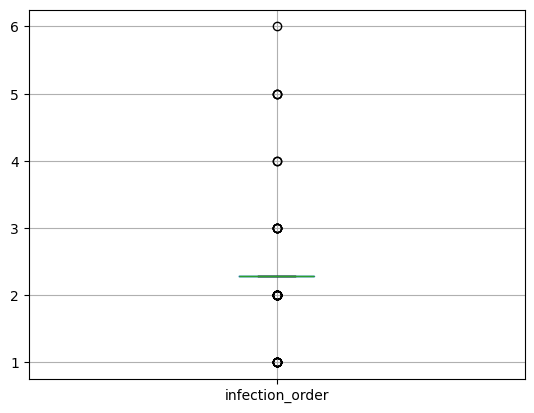

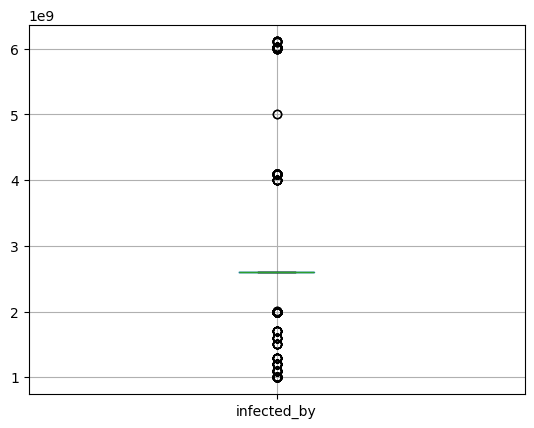

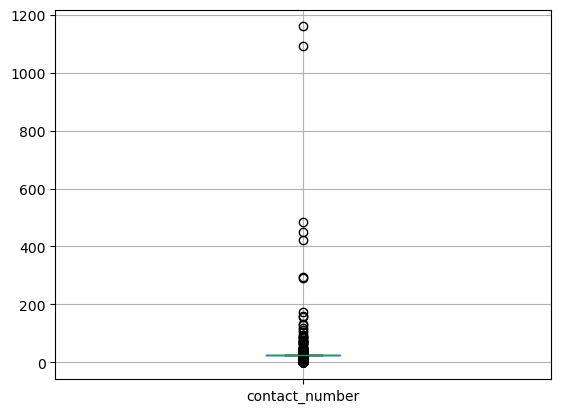

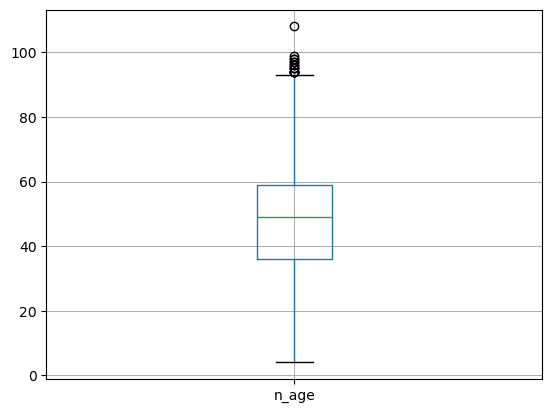

In [39]:
df_num_state = df.select_dtypes('number')
df_num_state['state'] = df['state']
for col in df.select_dtypes('number').columns:
    plt.figure()
    df[[col]].boxplot()

#df.boxplot(by='state', figsize=(10,10))

AP: birth_year, age_group, & n_age seem to have at least one outlier each. The outliers seem consistent with each other suggesting a single observation rather than multiple

In [40]:
df['n_age'].max()
#AP: the 'outlier' can be considered consistent with human lifespans, not actually an outlier

108.0

**<font color='teal'> Create dummy features for object type features. </font>**

AP: note that creating dummies will create a LOT of extra cols: 'city': 134 new cols, 'infection_case': 16 new cols
    'infection_case isn't so bad but I don't see the value in creating dummies for 'city'

In [41]:
print('dtypes:\n', df.dtypes)

#AP: make a list of the object type col names
cols_obj = list(df.select_dtypes('object').columns)
print('\nObject col names list:\n', cols_obj)

dtypes:
 patient_id           int64
global_num         float64
sex                 object
birth_year         float64
age_group          float64
country             object
province            object
city                object
disease             object
infection_case      object
infection_order    float64
infected_by        float64
contact_number     float64
state               object
n_age              float64
dtype: object

Object col names list:
 ['sex', 'country', 'province', 'city', 'disease', 'infection_case', 'state']


In [42]:
#AP: for getting an idea of how get_dummies will expand my dataset
for col in df[cols_obj]:
    print(f'\ncolumn: {col}: (len: {len(pd.unique(df[col]))})\n',
        pd.unique(df[col]))


column: sex: (len: 2)
 ['male' 'female']

column: country: (len: 4)
 ['Korea' 'China' 'Mongolia' 'Thailand']

column: province: (len: 17)
 ['Seoul' 'Busan' 'Daegu' 'Gwangju' 'Incheon' 'Daejeon' 'Ulsan' 'Sejong'
 'Gyeonggi-do' 'Gangwon-do' 'Chungcheongbuk-do' 'Chungcheongnam-do'
 'Jeollabuk-do' 'Jeollanam-do' 'Gyeongsangbuk-do' 'Gyeongsangnam-do'
 'Jeju-do']

column: city: (len: 134)
 ['Gangseo-gu' 'Jungnang-gu' 'Jongno-gu' 'Mapo-gu' 'Seongbuk-gu' 'etc'
 'Songpa-gu' 'Seodaemun-gu' 'Seongdong-gu' 'Seocho-gu' 'Guro-gu'
 'Gangdong-gu' 'Eunpyeong-gu' 'Geumcheon-gu' 'Gwanak-gu' 'Nowon-gu'
 'Dongjak-gu' 'Gangnam-gu' 'Yangcheon-gu' 'Gwangjin-gu' 'Dongdaemun-gu'
 'Yeongdeungpo-gu' 'Dobong-gu' 'Yongsan-gu' 'Gangbuk-gu' 'Jung-gu'
 'Dongnae-gu' 'Haeundae-gu' 'Yeonje-gu' 'Gyeongsan-si' 'Buk-gu' 'Nam-gu'
 'Seo-gu' 'Geumjeong-gu' 'Saha-gu' 'Suyeong-gu' 'Sasang-gu' 'Busanjin-gu'
 'Dalseo-gu' 'Dalseong-gun' 'Suseong-gu' 'Dong-gu' 'Wuhan' 'Bupyeong-gu'
 'Michuhol-gu' 'Yeonsu-gu' 'Gyeyang-gu' 'Namdong-g

In [48]:
df_dum = pd.get_dummies(df.drop('state', axis=1))
#AP: need to drop 'state' col here so it's not dummie'd
df_dum.head()

,patient_id,global_num,birth_year,age_group,infection_order,infected_by,contact_number,n_age,sex_female,sex_male,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow,infection_case_unknown
0,1000000001,2.0,1964.0,50.0,1.0,2.600789e+09,75.0,60.0,False,True,...,False,False,False,False,False,False,False,False,True,False
1,1000000002,5.0,1987.0,30.0,1.0,2.600789e+09,31.0,37.0,False,True,...,False,False,False,False,False,False,False,False,True,False
2,1000000003,6.0,1964.0,50.0,2.0,2.002000e+09,17.0,60.0,False,True,...,False,False,False,False,False,True,False,False,False,False
3,1000000004,7.0,1991.0,20.0,1.0,2.600789e+09,9.0,33.0,False,True,...,False,False,False,False,False,False,False,False,True,False
4,1000000005,9.0,1992.0,20.0,2.0,1.000000e+09,2.0,32.0,True,False,...,False,False,False,False,False,True,False,False,False,False


### Split the data into test and train subsamples

In [49]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
X = df_dum
y = df['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [50]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [51]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [52]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.872
Random Forest: f1-score=0.842


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [53]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  7   0   0]
 [  0 363   5]
 [  0  52  17]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.99 0.01]
 [0.   0.75 0.25]]


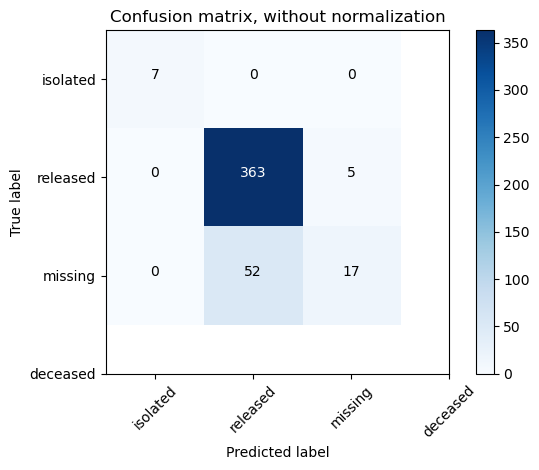

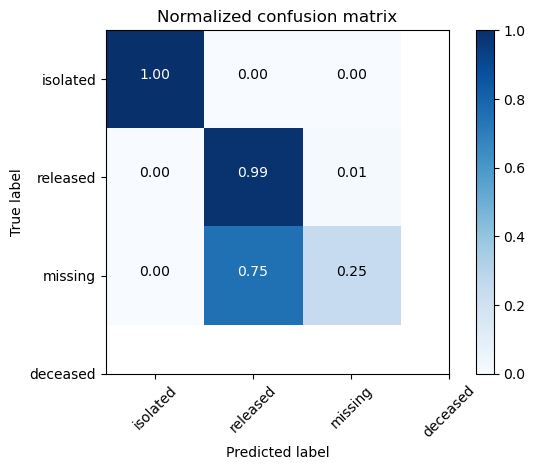

In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


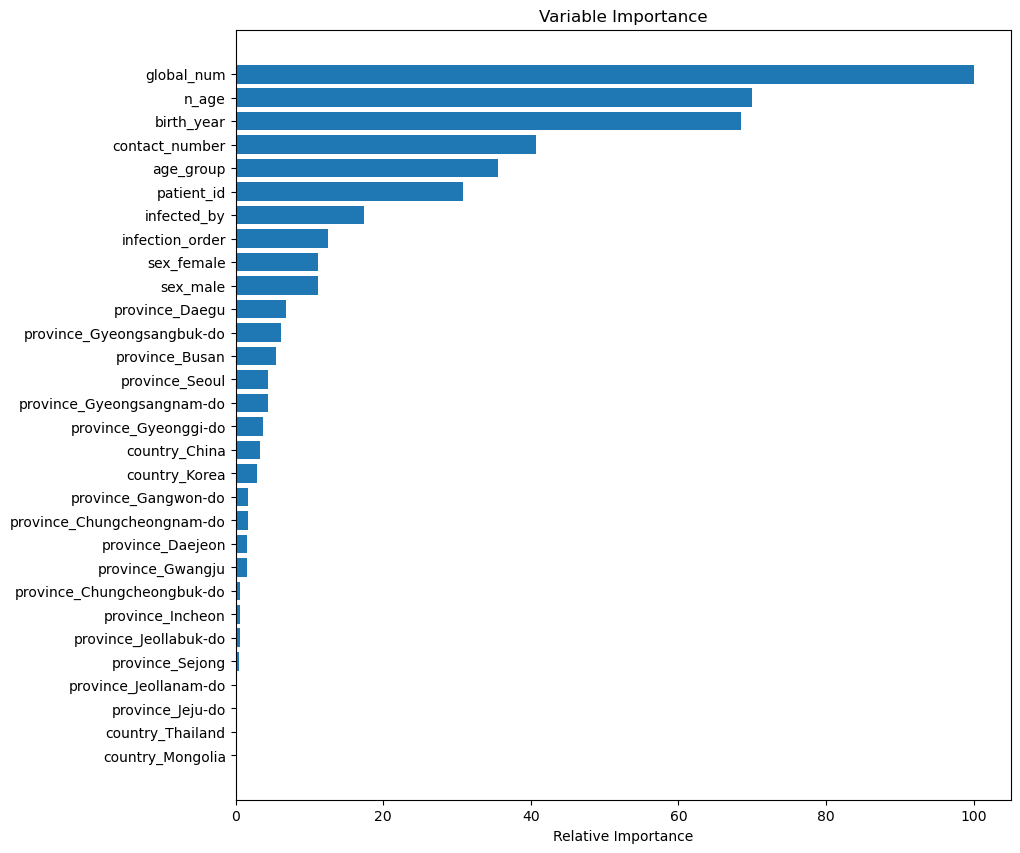

In [55]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.